<a href="https://colab.research.google.com/github/AShar97/american-option/blob/main/American_Options.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline

In [2]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [3]:
import numpy as np
import scipy.linalg as linalg
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt

from tqdm.autonotebook import tqdm

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  


In [4]:
def DirectSolveCryersProblem(A, b, g, size):
    P, L, U = linalg.lu(A)
    assert (P == np.identity(size)).all()
    A_=L
    b_=linalg.lu_solve(linalg.lu_factor(U), b)
    w = np.zeros(size)
    for i in range(size):
        w[i] = np.maximum((b_[i] - np.matmul(A_[i, :i], w[:i]))/A_[i, i], g[i])
    return w

def PSORSolveCryersProblem(A, b, g, size, omega_r, max_iter, error_tolerance):
    b_ = b - np.matmul(A, g)
    r = np.zeros(size)
    w_ = np.zeros(size)
    w = np.zeros(size)
    for k in range(int(max_iter)):
        for i in range(size):
            r[i] = b_[i] - np.matmul(A[i, :], w)
            w[i] = np.maximum( 0, w[i] + omega_r*r[i]/A[i, i] )
        if ( np.sum( w - w_ ) < error_tolerance ).all():
            break
        else:
            w_ = w
        assert K != max_iter-1
    return w + g

In [5]:
def SolveCryersProblem(A, b, g, size, useDirectVsPSOR, omega_r, max_iter, error_tolerance):
    if useDirectVsPSOR:
        w = DirectSolveCryersProblem(A, b, g, size)
    else:
        w = PSORSolveCryersProblem(A, b, g, size, omega_r, max_iter, error_tolerance)
    return w

In [6]:
def AmericanOptionPricerFD(K, T, S0, r, delta, sigma, solveCallVsPut, useDirectVsPSOR, M=100, N=100, Xr=5):
    #Linear Complementarity Problem
    q = 2*r/(sigma**2)
    q_delta = 2*(r-delta)/(sigma**2)
    if solveCallVsPut:
        g = lambda x, tau: \
        np.exp( .25*tau*((q_delta-1)**2 + 4*q) ) * np.maximum( np.exp(.5*x*(q_delta+1)) - np.exp(.5*x*(q_delta-1)), 0 )
    else:
        g = lambda x, tau: \
        np.exp( .25*tau*((q_delta-1)**2 + 4*q) ) * np.maximum( np.exp(.5*x*(q_delta-1)) - np.exp(.5*x*(q_delta+1)), 0 )
    
    #Prototype Core Algorithm
    # theta=0 (explicit), theta=0.5 (Crank–Nicolson), theta=1 (backward-difference method)
    theta = 0.5 #Crank-Nicolson
    #PSOR
    omega_r = 1 #1<=omega_r<2
    max_iter = 1e5
    error_tolerance = 1e-5

    x0, x1 = -Xr, Xr
    tau0, tau1 = 0, 0.5*(sigma**2)*T
    m, n = M, N

    dx = (x1-x0)/m
    dtau = (tau1-tau0)/n

    X = np.linspace(x0, x1, num=m+1)
    Tau = np.linspace(tau0, tau1, num=n+1)

    #Discretization with Finite Differences
    logging.info("Discretization with Finite Differences")
    lamda = dtau/(dx**2)
    alpha = lamda*theta
    A = (np.diag((1+2*alpha)*np.ones(m-1), k=0) +
         np.diag(np.diag(-alpha*np.ones(m-2), k=-1)) +
         np.diag(np.diag(-alpha*np.ones(m-2), k=1))
         )
    b = np.zeros(m-1)
    W = np.zeros((m+1, n+1))
    W[:, 0] = g(X, Tau[0])
    W[0, :] = g(X[0], Tau)
    W[-1, :] = g(X[-1], Tau)
    for j in tqdm(range(n)):
        w = W[1:-1, j]
        b[0] = w[0] + lamda*(1-theta)*(w[1] - 2*w[0] + W[0, j]) + alpha*W[0, j+1]
        b[-1] = w[-1] + lamda*(1-theta)*(w[-1] - 2*w[-1] + W[-1, j]) + alpha*W[-1, j+1]
        b[1:-1] = w[1:-1] + lamda*(1-theta)*(w[:-2] - 2*w[1:-1] + w[2:])

        #Solving Cryers-Problem
        W[1:-1, j+1] = SolveCryersProblem(A, b, g(X[1:-1], Tau[j+1]), m-1, useDirectVsPSOR, omega_r, max_iter, error_tolerance)
    
    #Back-transformation
    logging.info("Back-transformation")
    S_range = K*np.exp(X)
    T_range = T - 2*Tau/(sigma**2)
    V = np.zeros_like(W)
    for j in tqdm(range(n+1)):
        V[:, j] = K * W[:, j] * np.exp( -.5 * X * (q_delta-1) ) * np.exp( -.25 * Tau[j] * ( .25 * (q_delta-1)**2 + q ) )
    
    #Test Early-exercise
    logging.info("Testing Early-exercise")
    epsilon = K*1e-5
    if solveCallVsPut:
        idx = np.where( np.abs((K-S_range + V[:, T_range==0])) < epsilon )[0].min()
        if S0>S_range[idx]:
            logging.info("\tIn stopping region.")
        else:
            logging.warning("\tOut of stopping region.")
    else:
        idx = np.where( np.abs((V[:, T_range==0] + S_range-K)) < epsilon )[0].max()
        if S0<S_range[idx]:
            logging.info("\tIn stopping region.")
        else:
            logging.warning("\tOut of stopping region.")
    
    return S_range, T_range, V

In [7]:
K, T, S0, r, delta, sigma = 10., 1., 10., .06, 0., .3

In [8]:
S_range, T_range, V = AmericanOptionPricerFD(
    K, T, S0, r, delta, sigma, solveCallVsPut=False, useDirectVsPSOR=True, M=1000, N=1000, Xr=2
    )

INFO:root:Discretization with Finite Differences


  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:root:Back-transformation


  0%|          | 0/1001 [00:00<?, ?it/s]

INFO:root:Testing Early-exercise
INFO:root:	In stopping region.


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


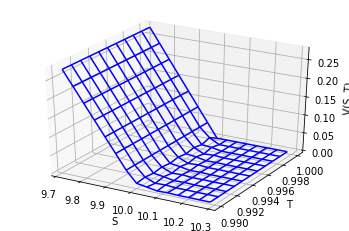

In [9]:
S_meshgrid, T_meshgrid = np.meshgrid(S_range, T_range, indexing='ij')

idxS = ( (.97*S0 < S_range) & (S_range < 1.03*S0) )
idxT = ( (.99*T <= T_range) & (T_range <= T) )

fig = plt.figure()
ax = plt.axes(projection="3d")
ax.plot_wireframe(S_meshgrid[idxS, :][:, idxT], T_meshgrid[idxS, :][:, idxT], V[idxS, :][:, idxT], color='Blue')
ax.set_xlabel('S')
ax.set_ylabel('T')
ax.set_zlabel('V(S, T)')

plt.show()

In [10]:
V[S_range==S0, T_range==0]

array([0.01025895])

In [11]:
S_range, T_range, V = AmericanOptionPricerFD(
    K, T, S0, r, delta, sigma, solveCallVsPut=False, useDirectVsPSOR=False, M=1000, N=1000, Xr=2
    )

INFO:root:Discretization with Finite Differences


  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:root:Back-transformation


  0%|          | 0/1001 [00:00<?, ?it/s]

INFO:root:Testing Early-exercise
INFO:root:	In stopping region.


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


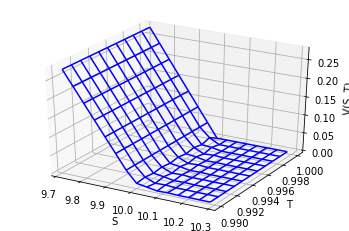

In [12]:
S_meshgrid, T_meshgrid = np.meshgrid(S_range, T_range, indexing='ij')

idxS = ( (.97*S0 < S_range) & (S_range < 1.03*S0) )
idxT = ( (.99*T <= T_range) & (T_range <= T) )

fig = plt.figure()
ax = plt.axes(projection="3d")
ax.plot_wireframe(S_meshgrid[idxS, :][:, idxT], T_meshgrid[idxS, :][:, idxT], V[idxS, :][:, idxT], color='Blue')
ax.set_xlabel('S')
ax.set_ylabel('T')
ax.set_zlabel('V(S, T)')

plt.show()

In [13]:
V[S_range==S0, T_range==0]

array([0.01025895])

In [14]:
def BSMModelRiskNeutralSimulation(T, S0, r, delta, sigma, M, N):
    dT = T/N
    T_range = np.linspace(0, T, num=N+1)
    sqrt_dT = np.sqrt(dT)

    assert M%2 == 0
    Z = np.random.normal(loc=0., scale=1., size=(M//2, N))
    Z = np.concatenate((Z, -Z), axis=0)

    S = np.zeros((M, N+1))
    S[:, 0] = S0
    for i in range(N):
        dW = Z[:, i]*sqrt_dT
        S[:, i+1] = S[:, i] * np.exp( (r - .5*sigma**2 - delta)*dT + sigma*dW )
    
    return T_range, S

In [15]:
def AmericanOptionPricerLongstaffSchwartz(K, T, S0, r, delta, sigma, solveCallVsPut, M=100000, N=100, regression_deg=10):
    #BSM-Model Risk-Neutral Simulation
    logging.info("BSM-Model Risk-Neutral Simulation")
    T_range, S = BSMModelRiskNeutralSimulation(T, S0, r, delta, sigma, M, N)

    #ExercisePayoff
    logging.info("Exercise Payoff")
    if solveCallVsPut:
        payoff = lambda S: np.maximum(S-K, 0)
    else:
        payoff = lambda S: np.maximum(K-S, 0)
    V_exercise = payoff(S)
    V = payoff(S)
    V_discountedExercisePayoff = V_exercise[:, -1]

    V_pred_discountedExercisePayoff = np.zeros_like(S)

    dT = T/N
    discountFunc = lambda t: np.exp(-r*t)

    discount_dT = discountFunc(dT)

    idxStoppingTime = (np.zeros((M, N+1)) == 0)
    idxStoppingTime[:, N] = True

    #BackwardComputation
    logging.info("Backward Computation")

    for i in tqdm(range(N-1, -1, -1)):
        V_discountedExercisePayoff *= discount_dT

        coeff = np.polynomial.laguerre.lagfit(S[:, i], V_discountedExercisePayoff, deg=regression_deg)
        V_pred_discountedExercisePayoff[:, i] = np.polynomial.laguerre.lagval(S[:, i], coeff)
        
        idxExericise = (V_exercise[:, i] > V_pred_discountedExercisePayoff[:, i])
        
        idxStoppingTime[idxExericise, :] = False
        idxStoppingTime[idxExericise, i] = True

        V_discountedExercisePayoff[idxExericise] = V_exercise[idxExericise, i]

        V[:, i] = V_discountedExercisePayoff
    
    return S, T_range, V, V_pred_discountedExercisePayoff, V[:, 0].mean(), V[:, 0].std()

In [16]:
K, T, S0, r, delta, sigma = 10., 1., 10., .06, 0., .3 #40., 1., 42., .06, 0., .2

In [17]:
S, T_range, V, V_pred, V_mean, V_sd = AmericanOptionPricerLongstaffSchwartz(
    K, T, S0, r, delta, sigma, solveCallVsPut=False, M=100000, N=100, regression_deg=100
    )

INFO:root:BSM-Model Risk-Neutral Simulation
INFO:root:Exercise Payoff
INFO:root:Backward Computation


  0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/numpy/polynomial/laguerre.py:1391: RankWarning: The fit may be poorly conditioned
  return pu._fit(lagvander, x, y, deg, rcond, full, w)


In [18]:
V_mean, V_sd

(0.9530152665122212, 1.0579237424470813)